# Data Preprocessing

Preprocess the [Long-Term Movement Monitoring Database](https://www.physionet.org/physiobank/database/ltmm/) from PhysioNet to allow for training machine learning classifiers to distinguish fallers vs. non-fallers. 

There are 2 datasets included: (1) a 3-day 3D measurement; (2) a lab gait assessment walking "for 1 minute at a comfortable, self-selected speed"

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import os

In [4]:
import pandas as pd

In [5]:
import pickle

In [6]:
import wfdb

In [7]:
%matplotlib inline

## Data format

Explore the data format/structure with CO001 (a non-faller) as an example "record" from the 3-day 3D measurements

In [14]:
plt.style.use(['dark_background'])

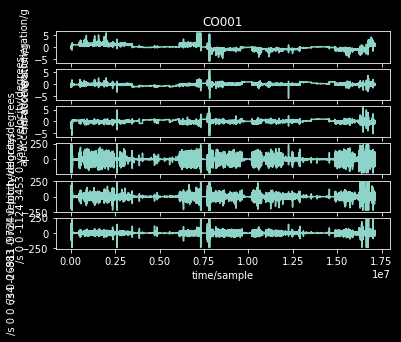

{'record_name': 'CO001',
 'n_sig': 6,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 17141698,
 'base_time': None,
 'base_date': None,
 'comments': ['Age:75.17', 'Sex:F'],
 'sig_name': ['v-acceleration',
  'ml-acceleration',
  'ap-acceleration',
  '/s 0 0 -1124 3453 0 yaw-velocity',
  '/s 0 0 -883 -9724 0 pitch-velocity',
  '/s 0 0 634 -26911 0 roll-velocity'],
 'p_signal': array([[-0.02430932, -0.00709566, -1.05035309,  0.19197293,  2.66644846,
          0.00706453],
        [-0.0214494 , -0.00709566, -1.05905317,  0.27424704,  0.83943748,
         -0.01412905],
        [-0.02430932, -0.00993393, -1.0619532 ,  0.39080203, -0.04937868,
         -0.02119358],
        ...,
        [ 0.67672869, -0.35070308, -0.67896854, -0.78160406,  4.26067426,
         -0.18367769],
        [ 0.67672869, -0.35354135, -0.67896854, -1.07641962,  4.12664643,
         -0.31083917],
        [ 0.68244853, -0.35070308, -0.67606851, -1.51521488,  3.96440221,
         -0.50864592]]),
 'd_

In [8]:
record = wfdb.rdrecord(os.path.join('data', 'CO001')) 
wfdb.plot_wfdb(record=record, title='CO001') 
display(record.__dict__)

and similarly for the 1 min. lab gait assessment

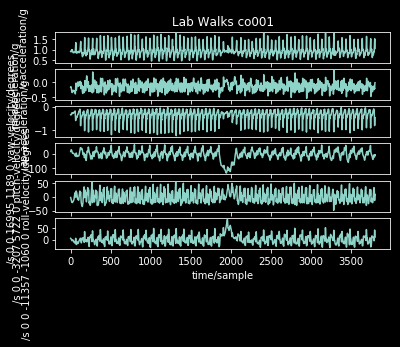

{'record_name': 'co001_base',
 'n_sig': 6,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 3801,
 'base_time': None,
 'base_date': None,
 'comments': ['Age:75.17', 'Sex:F'],
 'sig_name': ['v-acceleration',
  'ml-acceleration',
  'ap-acceleration',
  '/s 0 0 16995 1189 0 yaw-velocity',
  '/s 0 0 -3207 5722 0 pitch-velocity',
  '/s 0 0 -11357 -1060 0 roll-velocity'],
 'p_signal': array([[ 9.17030921e-01, -1.63281940e-01, -3.42359758e-01,
          1.65484292e+01, -2.94991384e+00,  6.40017927e+00],
        [ 9.25608325e-01, -1.54757180e-01, -3.51063199e-01,
          1.89887931e+01, -4.23962180e+00,  6.20966406e+00],
        [ 9.28467460e-01, -1.51920345e-01, -3.53970441e-01,
          2.14383658e+01, -5.55277899e+00,  5.68716195e+00],
        ...,
        [ 1.33189762e+00, -3.26592391e-02, -6.09277496e-01,
         -8.60420093e+00,  8.09154957e+00,  2.53366366e+01],
        [ 1.12017557e+00, -1.84608095e-02, -5.16446878e-01,
         -1.00438621e+01,  9.12956906e+00

In [15]:
record2 = wfdb.rdrecord(os.path.join('data', 'LabWalks', 'co001_base')) 
wfdb.plot_wfdb(record=record2, title='Lab Walks co001') 
display(record2.__dict__)

---

Get list of all records (all files w/ .hea or .dat extension)

In [12]:
records3day = tuple([os.path.splitext(f)[0] for f in os.listdir('data') if '.hea' in f])

In [22]:
len(records3day)

71

In [16]:
records1min = tuple([os.path.splitext(f)[0] for f in os.listdir('data/LabWalks') if '.hea' in f])

In [23]:
len(records1min)

73

Records in the 1 min. cohort but not in the 3-day set, and vice versa:

In [24]:
print( set([x.split('_')[0] for x in records1min]) - set([x.lower() for x in records3day]) )

{'fl017', 'co026', 'fl013', 'co033', 'fl037', 'fl039', 'fl038', 'fl003', 'co034'}


In [25]:
print( set([x.lower() for x in records3day]) - set([x.split('_')[0] for x in records1min]) )

{'co038', 'co044', 'fl014', 'co039', 'co037', 'fl029', 'co012'}


Create $m\times n$ input feature matrix where $m$ = number of records and $n$ = 6, for the 3D measurements (3 linear acceleration + 3 angular velocity). First check that each record has the same order of the 6 measurements

In [22]:
feats = {tuple([x.split(' ')[-1] for x in wfdb.rdrecord(os.path.join('data', 'LabWalks', rec)).sig_name]) for rec in records1min}
print(len(feats) == 1)

True


Iterate over each record, read in the gait data, calculate the range for each feature and populate the input feature matrix

In [10]:
def feature_range(rec_tuple, read_dir):
    """ Parameters: recs: <tuple> of records
                    read_dir: <string> dir containing records"""
    if not isinstance(rec_tuple, tuple):
        raise Exception('Wrong input; argument must be tuple')
    colnames = ['v-acceleration', 'ml-acceleration', 'ap-acceleration', 
                'yaw-velocity', 'pitch-velocity', 'roll-velocity']
    num_recs = len(rec_tuple)
    df = pd.DataFrame(np.empty((num_recs, 6)), index=rec_tuple, columns=colnames)
    for i in range(num_recs):
        rec = wfdb.rdrecord(os.path.join(read_dir, rec_tuple[i]))
        df.iloc[i, :] = np.ptp(rec.p_signal, axis=0)
    
    return df

In [26]:
X_3day = feature_range(records3day, 'data')

In [30]:
X_1min = feature_range(records1min, 'data/LabWalks')

In [46]:
y_3day = np.array([1 if x[:2] == 'FL' else 0 for x in records3day])

In [47]:
y_1min = np.array([1 if x[:2] == 'fl' else 0 for x in records1min])

Save with pickle

In [48]:
with open('data_proc/range_3day.pkl', 'wb') as f:
    pickle.dump(X_3day, f)
    pickle.dump(y_3day, f)
with open('data_proc/range_1min.pkl', 'wb') as f:
    pickle.dump(X_1min, f)
    pickle.dump(y_1min, f)